<a href="https://colab.research.google.com/github/shyam1234/AIML_RND/blob/master/RealTimeFaceRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real-Time Face Recognition: An End-To-End Project



*   Face Detection and Data Gathering
*   Train the Recognizer
*   Face Recognition

In [ ]:
import numpy as np
import cv2

In [ ]:
cv2.__version__

Using a webcam to capture images for processing on the runtime.

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
img = cv2.imread('photo.jpg', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

Testing Your Camera

In [ ]:
img = cv2.imread('photo.jpg', cv2.IMREAD_UNCHANGED)
cap = cv2.VideoCapture(cv2_imshow(img))
cap.set(3,640) # set Width
cap.set(4,480) # set Height
while(True):
    ret, frame = cap.read()
    frame = cv2.flip(frame, -1) # Flip camera vertically
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    cv2_imshow(img)
    cv2_imshow(gray)
    break
    # k = cv2.waitKey(30) & 0xff
    # if k == 27: # press 'ESC' to quit
    #     break
cap.release()
cv2.destroyAllWindows()

# Face Detection

In [ ]:
# faceCascade = cv2.CascadeClassifier('Cascades/haarcascade_frontalface_default.xml')
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
image = cv2.imread('photo.jpg', cv2.IMREAD_UNCHANGED)
cap = cv2.VideoCapture(cv2_imshow(image))
cap.set(3,640) # set Width
cap.set(4,480) # set Height
count = 0 
while count < 5:
    count = count + 1
    ret = cap.read()
    image = cv2.flip(image, -1)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # cv2_imshow(image)
    # cv2_imshow(gray)
    faces = faceCascade.detectMultiScale(
        image,     
        scaleFactor=1.2,
        minNeighbors=5,     
        minSize=(20, 20)
    )
    for (x,y,w,h) in faces:
        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = image[y:y+h, x:x+w]  
    cv2_imshow(image)
    # break
    # k = cv2.waitKey(30) & 0xff
    # if k == 27: # press 'ESC' to quit
    #     break
cap.release()
cv2.destroyAllWindows()

# Data Gathering

In [ ]:
img = cv2.imread('photo.jpg', cv2.IMREAD_UNCHANGED)
cam = cv2.VideoCapture(cv2_imshow(img))
# cam = cv2.VideoCapture(0)
cam.set(3, 640) # set video width
cam.set(4, 480) # set video height
face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# For each person, enter one numeric face id
face_id = input('\n enter user id end press <return> ==>  ')
print("\n [INFO] Initializing face capture. Look the camera and wait ...")
# Initialize individual sampling face count
count = 0
while(True):
    ret = cam.read()
    img = cv2.flip(img, -1) # flip video image vertically
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_detector.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        cv2.rectangle(img, (x,y), (x+w,y+h), (255,0,0), 2)     
        count += 1
        # Save the captured image into the datasets folder
        cv2.imwrite("/content/dataset/User." + str(face_id) + '.' +  
                    str(count) + ".jpg", gray[y:y+h,x:x+w])
        cv2_imshow(img)
    k = cv2.waitKey(100) & 0xff # Press 'ESC' for exiting video
    if k == 27:
        break
    elif count >= 30: # Take 30 face sample and stop video
         break
# Do a bit of cleanup
print("\n [INFO] Exiting Program and cleanup stuff")
cam.release()
cv2.destroyAllWindows()

# Trainer

In [38]:
from PIL import Image
import os
# Path for face image database
path = '/content/dataset'
recognizer = cv2.face.LBPHFaceRecognizer_create()
detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# function to get the images and label data
def getImagesAndLabels(path):
    imagePaths = [os.path.join(path,f) for f in os.listdir(path)]     
    faceSamples=[]
    ids = []
    for imagePath in imagePaths:
        PIL_img = Image.open(imagePath).convert('L') # grayscale
        img_numpy = np.array(PIL_img,'uint8')
        id = int(os.path.split(imagePath)[-1].split(".")[1])
        faces = detector.detectMultiScale(img_numpy)
        for (x,y,w,h) in faces:
            faceSamples.append(img_numpy[y:y+h,x:x+w])
            ids.append(id)
    return faceSamples,ids
print ("\n [INFO] Training faces. It will take a few seconds. Wait ...")
faces,ids = getImagesAndLabels(path)
recognizer.train(faces, np.array(ids))
# Save the model into trainer/trainer.yml
recognizer.write('/content/trainer/trainer.yml') 
# Print the numer of faces trained and end program
print("\n [INFO] {0} faces trained. Exiting Program".format(len(np.unique(ids))))


 [INFO] Training faces. It will take a few seconds. Wait ...

 [INFO] 1 faces trained. Exiting Program


# Recognizer

<IPython.core.display.Javascript object>

Saved to photo.jpg


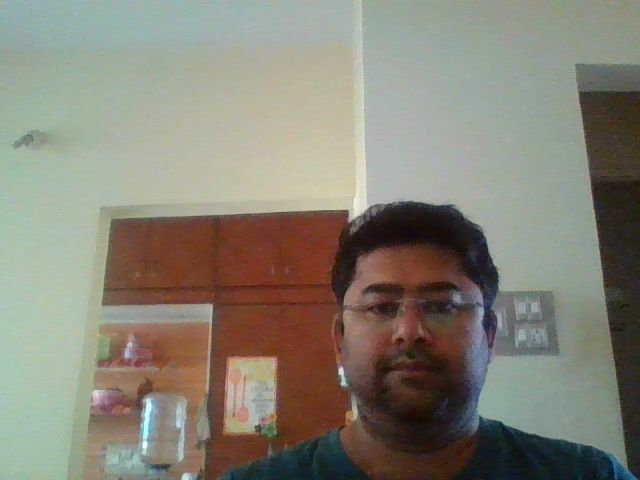

In [52]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

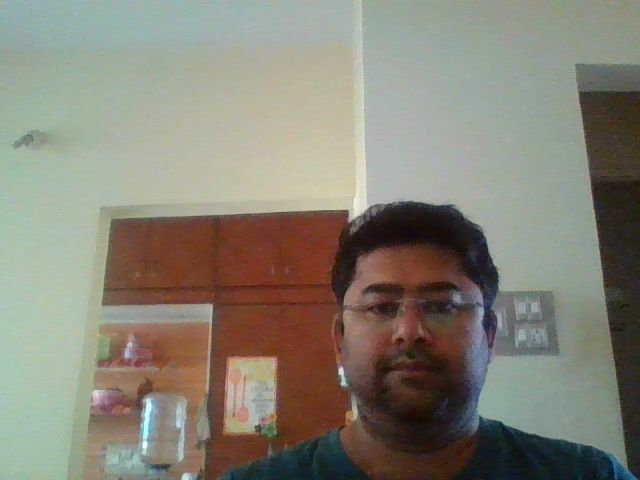

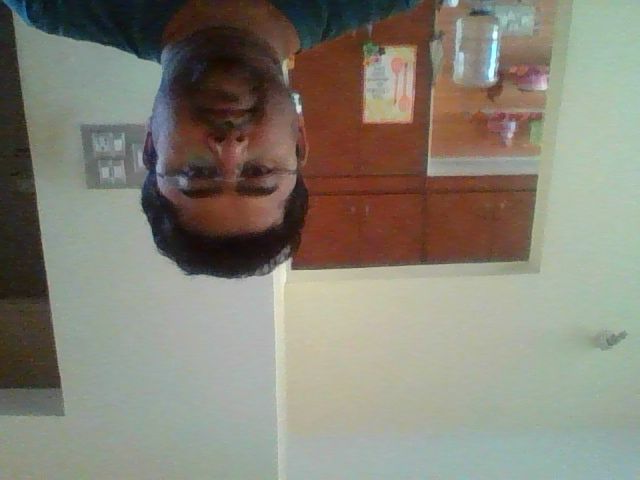

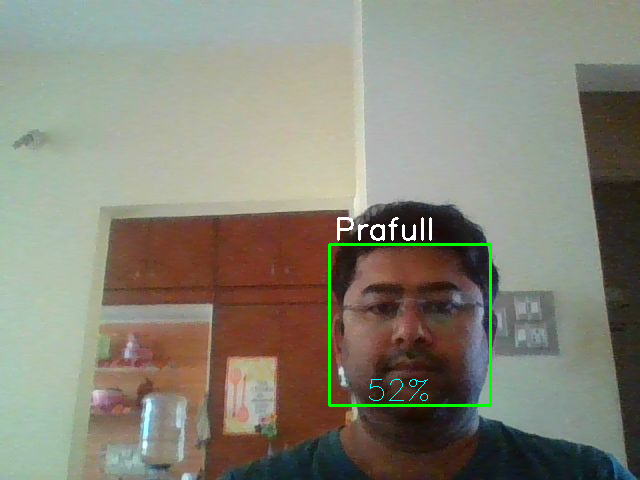

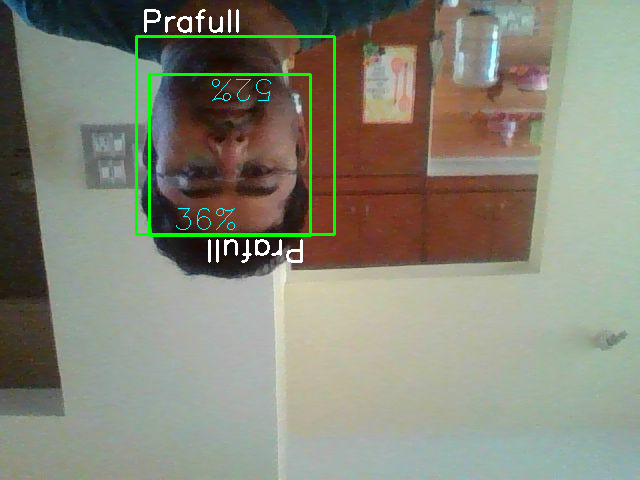

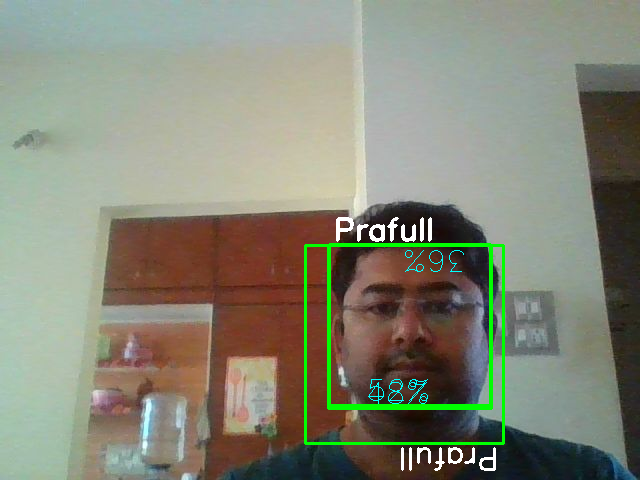

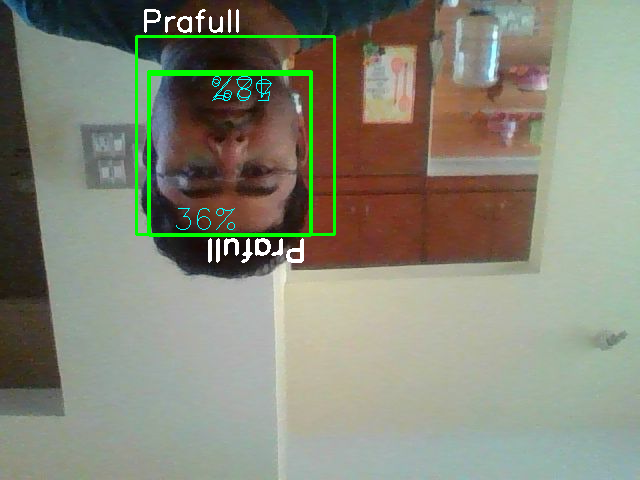

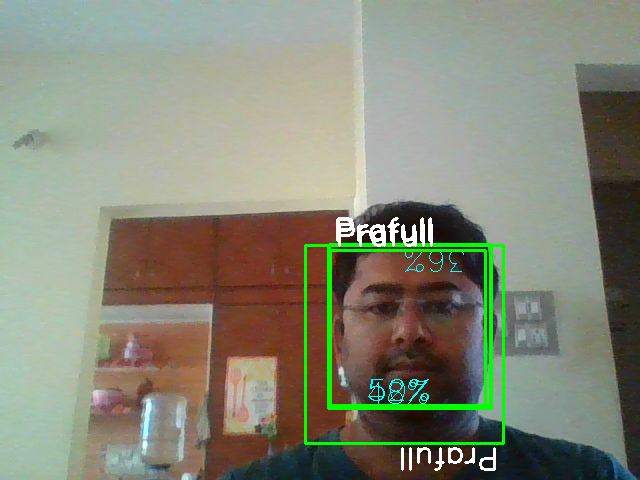

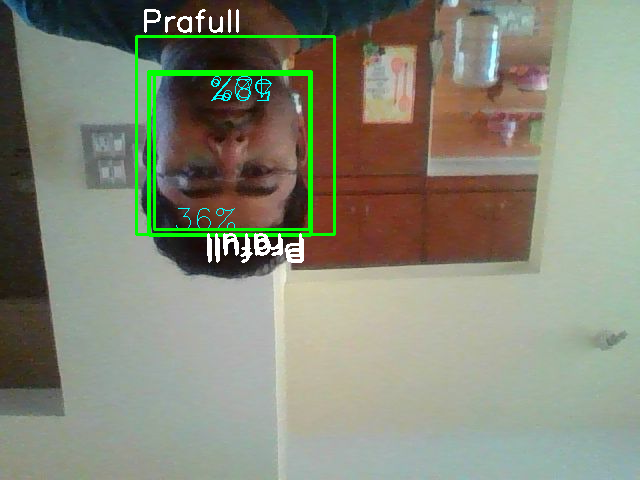

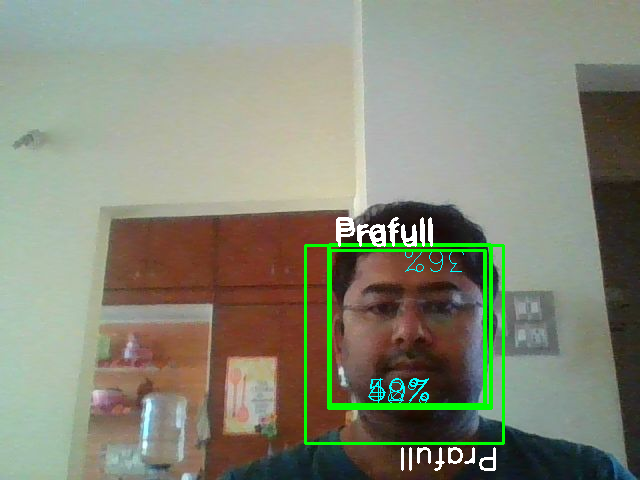

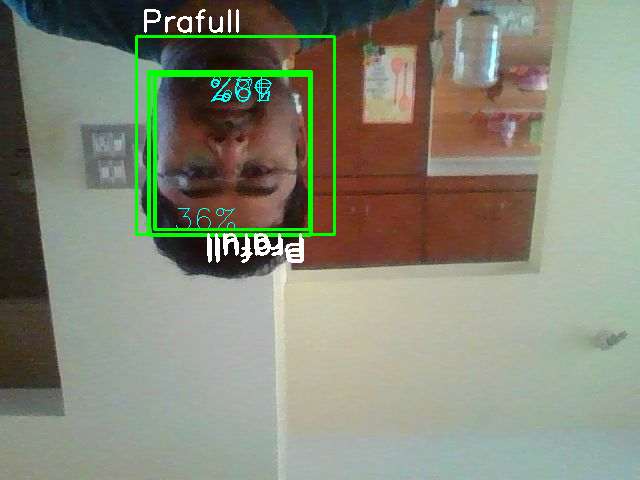

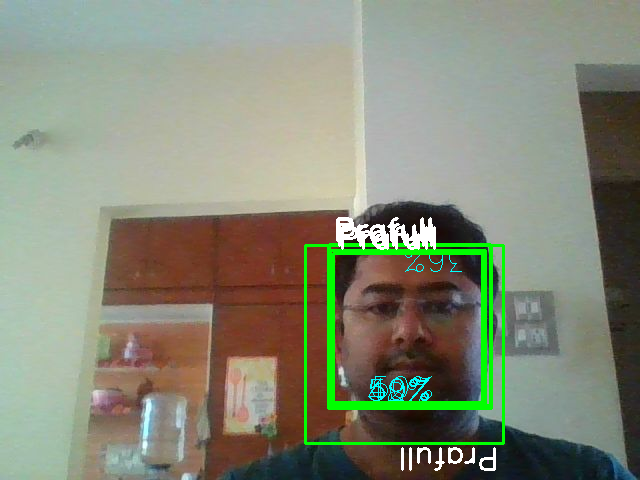


 [INFO] Exiting Program and cleanup stuff


In [53]:
recognizer = cv2.face.LBPHFaceRecognizer_create()
recognizer.read('/content/trainer/trainer.yml')
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
font = cv2.FONT_HERSHEY_SIMPLEX
#iniciate id counter
id = 0
# names related to ids: example ==> Prafull: id=1,  etc
names = ['None', 'Prafull', 'Akhansha', 'Face3', 'Face4', 'Face5'] 
# Initialize and start realtime video capture
# cam = cv2.VideoCapture(0)
img = cv2.imread('photo.jpg', cv2.IMREAD_UNCHANGED)
cam = cv2.VideoCapture(cv2_imshow(img))
cam.set(3, 640) # set video widht
cam.set(4, 480) # set video height
# Define min window size to be recognized as a face
minW = 0.1*cam.get(3)
minH = 0.1*cam.get(4)
count =0 
while count < 10:
    ret =cam.read()
    img = cv2.flip(img, -1) # Flip vertically
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    faces = faceCascade.detectMultiScale( 
        gray,
        scaleFactor = 1.2,
        minNeighbors = 5,
        minSize = (int(minW), int(minH)),
       )
    for(x,y,w,h) in faces:
        cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)
        id, confidence = recognizer.predict(gray[y:y+h,x:x+w])
        
        # If confidence is less them 100 ==> "0" : perfect match 
        if (confidence < 100):
            id = names[id]
            confidence = "  {0}%".format(round(100 - confidence))
        else:
            id = "unknown"
            confidence = "  {0}%".format(round(100 - confidence))
        
        cv2.putText(
                    img, 
                    str(id), 
                    (x+5,y-5), 
                    font, 
                    1, 
                    (255,255,255), 
                    2
                   )
        cv2.putText(
                    img, 
                    str(confidence), 
                    (x+5,y+h-5), 
                    font, 
                    1, 
                    (255,255,0), 
                    1
                   )  
    
    cv2_imshow(img) 
    count+=1
    # k = cv2.waitKey(10) & 0xff # Press 'ESC' for exiting video
    # if k == 27:
    #     break
# Do a bit of cleanup
print("\n [INFO] Exiting Program and cleanup stuff")
cam.release()
cv2.destroyAllWindows()